## Develop and test theano flow to generate melspectrograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from librosa.feature import melspectrogram
from scipy.io.wavfile import read as readwav
from scipy.signal import tukey

### Sample speech

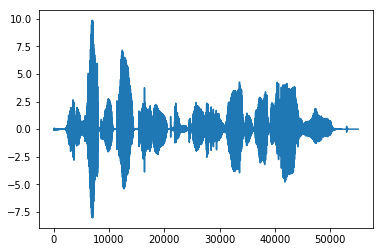

(55092,)


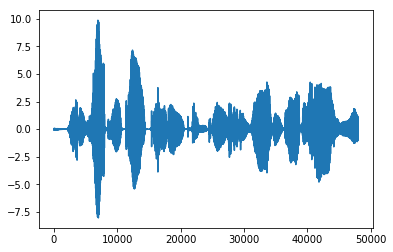

In [2]:
SR, aud = readwav('FADG0SA1.WAV')
aud = (aud - np.mean(aud)) / np.std(aud)
f1 = plt.figure()
plt.plot(aud)
plt.show()
print aud.shape

samp = aud[:SR*3]
f2 = plt.figure()
plt.plot(samp)
plt.show()

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap 
between consecutive frames. Popular settings are 25 ms for the frame size, 
frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

### Output from librosa

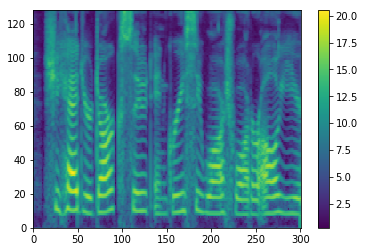

(128, 301)

In [38]:
lm = melspectrogram(y=samp.astype(np.float32),sr=SR,n_fft=1024,hop_length=160)
plt.pcolormesh(np.log(1 + 10000*lm))
plt.colorbar()
plt.show()
lm.shape

### melspectrogram using numpy

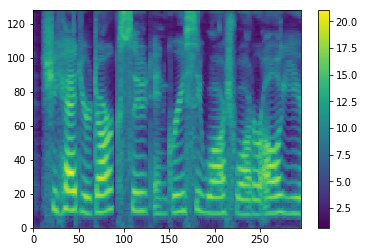

In [54]:
flength = 1024
fstep = 160
NFFT = 1024

#generate frames
nf = int(np.ceil((3*SR - flength) / np.float(fstep)))
plength = nf * fstep + flength
psamp = np.concatenate([samp,np.zeros(plength - 3*SR)])
fInd = np.tile(np.arange(0, flength), (nf + 1, 1)) + np.tile(np.arange(0, nf * fstep + 1, fstep), (flength, 1)).T
frames = psamp[fInd]
frames = frames * tukey(flength,alpha=0.5)
frames.shape
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
#get melspectrogram
nfilt = 128
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (SR / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / SR)
from librosa.filters import mel
fbank = mel(SR,NFFT)
filter_banks = np.dot(mag_frames**2, fbank.T)
filter_banks = np.log(1 + 10000*filter_banks)
f1 = plt.figure()
plt.pcolormesh(filter_banks.T)
plt.colorbar()
plt.show()

### Theano flow for melspectrogram

In [8]:
import theano
import theano.tensor as T

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


In [9]:
fsize = 0.025
fstride = 0.01
SR = 16000
SL = 3
C = 10000

#framing
flength = int(fsize * SR)
fstep = int(fstride * SR)
nf = int(np.ceil((SL*SR - flength) / np.float(fstep)))
plength = nf * fstep + flength
psamp = np.concatenate([samp,np.zeros(plength - SL*SR)])
fInd = np.tile(np.arange(0, flength), (nf + 1, 1)) + np.tile(np.arange(0, nf * fstep + 1, fstep), (flength, 1)).T
#gen filter bank
nfilt = 128
NFFT = 1024
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (SR / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / SR)
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

In [10]:
samp2D = np.float32(np.vstack([aud[pivot*SR/5:SR*SL + pivot*SR/5] for pivot in range(3)]))
samp2D.shape

(3, 48000)

In [22]:
Sp = T.matrix('Sp')
sh_fInd = theano.shared(np.int32(fInd), borrow=True)
s_padded = T.concatenate([Sp,T.zeros([Sp.shape[0],plength - SL*SR])],axis=1)
twindow = theano.shared(np.float32(tukey(flength,alpha=0.5)), borrow=True)
frs = s_padded[:,sh_fInd] * twindow
p_frs = T.concatenate([frs,T.zeros([frs.shape[0],frs.shape[1],NFFT - frs.shape[2]])], axis=2)
p_frs = p_frs.reshape([p_frs.shape[0]*p_frs.shape[1],p_frs.shape[2]], ndim=2)
ffts = T.fft.rfft(p_frs)
spec = T.sqrt(T.sum(ffts**2,axis=2))
spec = spec.reshape([frs.shape[0],frs.shape[1],spec.shape[1]],ndim=3)
sh_fbank = theano.shared(fbank, borrow=True)
melspec = T.dot(np.int32(1)/np.float32(flength) * spec**2, sh_fbank.T)
log_spec = T.log(1 + C*melspec)

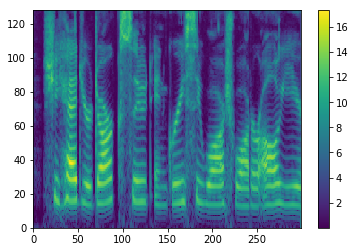

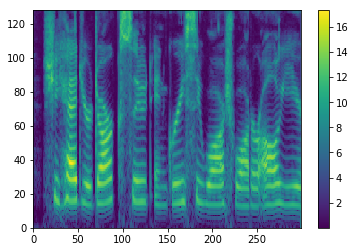

In [23]:
f1 = theano.function([Sp], log_spec)
plt.pcolormesh(f1(samp2D)[0].T)
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(filter_banks.T)
plt.colorbar()
plt.show()

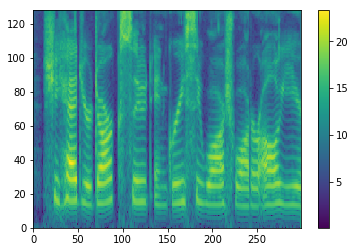

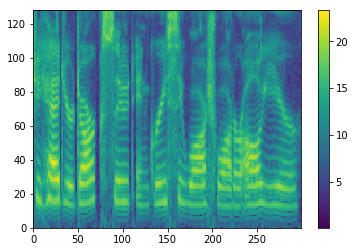

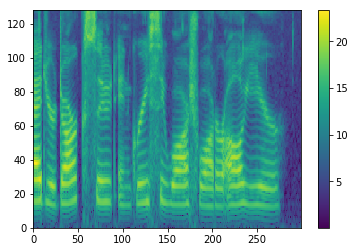

In [17]:
fx = theano.function([Sp],log_spec)
for i in range(3):
    f = plt.figure()
    plt.pcolormesh(fx(samp2D)[i].T)
    plt.colorbar()
    plt.show()